In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, lax, value_and_grad, checkpoint
import optax
import matplotlib.pyplot as plt
import numpy as np

# Enable 64-bit precision for numerical stability in multiphase flows
jax.config.update("jax_enable_x64", True)

# --- Physical Constants (based on Source 1, Table 1) ---
NX, NY = 100, 50       # Domain size [cite: 1645]
TAU_BRINE = 1.0        # Relaxation time (Brine)
TAU_CO2 = 0.6          # Relaxation time (CO2) - Lower viscosity
G_INT = -1.2           # Shan-Chen Interaction Strength (controls surface tension)
RHO_BRINE = 1.0        # Base density Brine
RHO_CO2_INIT = 0.1     # Base density CO2
D_SALT = 0.05          # Salt diffusion coefficient
K_SP = 1.1             # Solubility product threshold [cite: 1645]

# Lattice Weights (D2Q9)
W = jnp.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
CX = jnp.array([0, 1, 0, -1, 0, 1, -1, -1, 1])
CY = jnp.array([0, 0, 1, 0, -1, 1, 1, -1, -1])

print("JAX-LaB Environment Configured.")

JAX-LaB Environment Configured.


In [9]:
@jit
def collision_stream(f, salt_conc, mask, tau):
    """
    Combined Collision and Streaming Step.
    Includes Shan-Chen forces and Porous Media resistance.
    """
    # 1. Macroscopic moments
    rho = jnp.sum(f, axis=-1)
    u_x = jnp.sum(f * CX, axis=-1) / rho
    u_y = jnp.sum(f * CY, axis=-1) / rho
    
    # 2. Add Interaction Forces (Multiphase)
    fx, fy = interaction_force(rho, G_INT)
    u_x += fx / rho
    u_y += fy / rho
    
    # 3. Add Salt Drag (Feedback Loop) [cite: 1575]
    # If salt > K_SP, permeability drops (simulated as drag)
    precip_factor = jax.nn.sigmoid(10 * (salt_conc - K_SP)) 
    u_x *= (1.0 - precip_factor) 
    u_y *= (1.0 - precip_factor)

    # 4. Relaxation (BGK)
    f_eq = get_equilibrium(rho, u_x, u_y)
    f_out = f - (f - f_eq) / tau[..., None]
    
    # 5. Streaming (Memory efficient roll)
    for i in range(9):
        f_out = f_out.at[..., i].set(jnp.roll(f_out[..., i], (CX[i], CY[i]), axis=(0, 1)))
        
    # 6. Bounce-back at solid boundaries (Mask)
    # Simple bounce-back implementation for solid nodes
    f_out = f_out * (1 - mask[..., None]) + f * mask[..., None]
    
    return f_out, rho, u_x, u_y

In [3]:
@checkpoint # Gradient checkpointing to save VRAM 
def lbm_step(carry, pressure_in):
    f, salt, mask = carry
    
    # --- 1. Dynamic Boundary Condition (Zou-He) ---
    # Convert optimized pressure P(t) -> Density Injection
    # P ~ rho * cs^2. We modulate inlet density. [cite: 1634]
    rho_inlet = RHO_BRINE + pressure_in * 3.0 
    
    # Force inlet density (Left boundary x=0)
    # (Simplified Zou-He: Equilibrium update at inlet)
    f = f.at[0, :, :].set(get_equilibrium(rho_inlet, 0.1, 0.0))
    
    # --- 2. Fluid Solve ---
    # Determine local viscosity based on phase (CO2 vs Brine)
    rho_local = jnp.sum(f, axis=-1)
    # Linear interp of Tau based on density (multiphase proxy)
    tau_eff = TAU_CO2 + (TAU_BRINE - TAU_CO2) * (rho_local - RHO_CO2_INIT)/(RHO_BRINE - RHO_CO2_INIT)
    
    f_new, rho, ux, uy = collision_stream(f, salt, mask, tau_eff)
    
    # --- 3. Salt Transport & Reaction ---
    # Advection-Diffusion Equation for Salt [cite: 1570]
    # C_new = C + dt * (Div(D * Grad C) - Div(u * C))
    # (Simplified finite difference for demo)
    
    grad_salt_x = (jnp.roll(salt, -1, axis=0) - jnp.roll(salt, 1, axis=0)) / 2.0
    grad_salt_y = (jnp.roll(salt, -1, axis=1) - jnp.roll(salt, 1, axis=1)) / 2.0
    laplacian_salt = (jnp.roll(salt, -1, axis=0) + jnp.roll(salt, 1, axis=0) + 
                      jnp.roll(salt, -1, axis=1) + jnp.roll(salt, 1, axis=1) - 4*salt)
    
    # Advection term
    advection = -(ux * grad_salt_x + uy * grad_salt_y)
    diffusion = D_SALT * laplacian_salt
    
    salt_new = salt + (advection + diffusion)
    
    # Boundary conditions for salt (Source at inlet, Open outlet)
    salt_new = salt_new.at[0, :].set(0.0) # Fresh CO2 has no salt
    
    # Update Mask (Precipitation) if Salt > K_SP [cite: 1520]
    # Soft update for differentiability
    new_precip = jax.nn.sigmoid(100 * (salt_new - K_SP))
    mask_new = jnp.maximum(mask, new_precip) # Precipitation is irreversible
    
    # --- 4. Metrics ---
    # Saturation of CO2 (Volume fraction where rho < threshold)
    is_co2 = rho < (RHO_BRINE + RHO_CO2_INIT) / 2.0
    s_co2 = jnp.sum(is_co2 * (1-mask)) / jnp.sum(1-mask)
    
    return (f_new, salt_new, mask_new), s_co2

In [4]:
def run_simulation(pressure_schedule, initial_state):
    """
    Unrolls the physics loop over the time horizon defined by pressure_schedule.
    """
    # Run scan: efficient loop carrying state forward
    final_state, saturation_history = lax.scan(
        lbm_step, 
        initial_state, 
        pressure_schedule
    )
    return final_state, saturation_history

def loss_fn(pressure_schedule, initial_state):
    """
    Composite Loss Function [cite: 1612]
    L = (1 - S_CO2)^2 + lambda * sum(P^2)
    """
    LAMBDA_ENERGY = 0.05 # Regularization weight
    
    # Forward Pass
    final_state, s_hist = run_simulation(pressure_schedule, initial_state)
    
    # 1. Performance Loss: Minimize residual brine (Maximize CO2 Saturation)
    final_saturation = s_hist[-1]
    perf_loss = (1.0 - final_saturation)**2
    
    # 2. Energy/Risk Loss: Penalize high pressure spikes
    energy_loss = jnp.mean(pressure_schedule**2)
    
    total_loss = perf_loss + (LAMBDA_ENERGY * energy_loss)
    return total_loss

In [10]:
# --- Initialization ---
TIME_STEPS = 2000
# Initialize porous media mask (random obstacles)
key = jax.random.PRNGKey(42)
mask_init = jax.random.bernoulli(key, p=0.3, shape=(NX, NY)).astype(jnp.float64)
# Clear inlet/outlet
mask_init = mask_init.at[0:5, :].set(0.0).at[-5:, :].set(0.0)

# Initialize Fluid (All Brine initially)
rho_init = jnp.ones((NX, NY)) * RHO_BRINE
u_init = jnp.zeros((NX, NY))
f_init = get_equilibrium(rho_init, u_init, u_init)
salt_init = jnp.ones((NX, NY)) * 0.5 # Initial salinity
state_init = (f_init, salt_init, mask_init)

# Initialize Control Parameter (Pressure Schedule)
# Start with a constant low pressure guess
pressure_params = jnp.ones(TIME_STEPS) * 0.02 

# Optimizer Setup
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(pressure_params)

# JIT Compile the Gradient Function [cite: 1718]
grad_fn = jit(value_and_grad(loss_fn))

print("Starting Optimization...")

loss_history = []
# Optimization Loop
for epoch in range(51): # 50 Epochs
    loss_val, grads = grad_fn(pressure_params, state_init)
    
    updates, opt_state = optimizer.update(grads, opt_state)
    pressure_params = optax.apply_updates(pressure_params, updates)
    
    # Enforce physical constraints (Pressure > 0)
    pressure_params = jnp.maximum(pressure_params, 0.0)
    
    loss_history.append(loss_val)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss_val:.5f}")

print("Optimization Complete.")

Starting Optimization...
Epoch 0: Loss = nan
Epoch 10: Loss = nan
Epoch 20: Loss = nan
Epoch 30: Loss = nan
Epoch 40: Loss = nan
Epoch 50: Loss = nan
Optimization Complete.


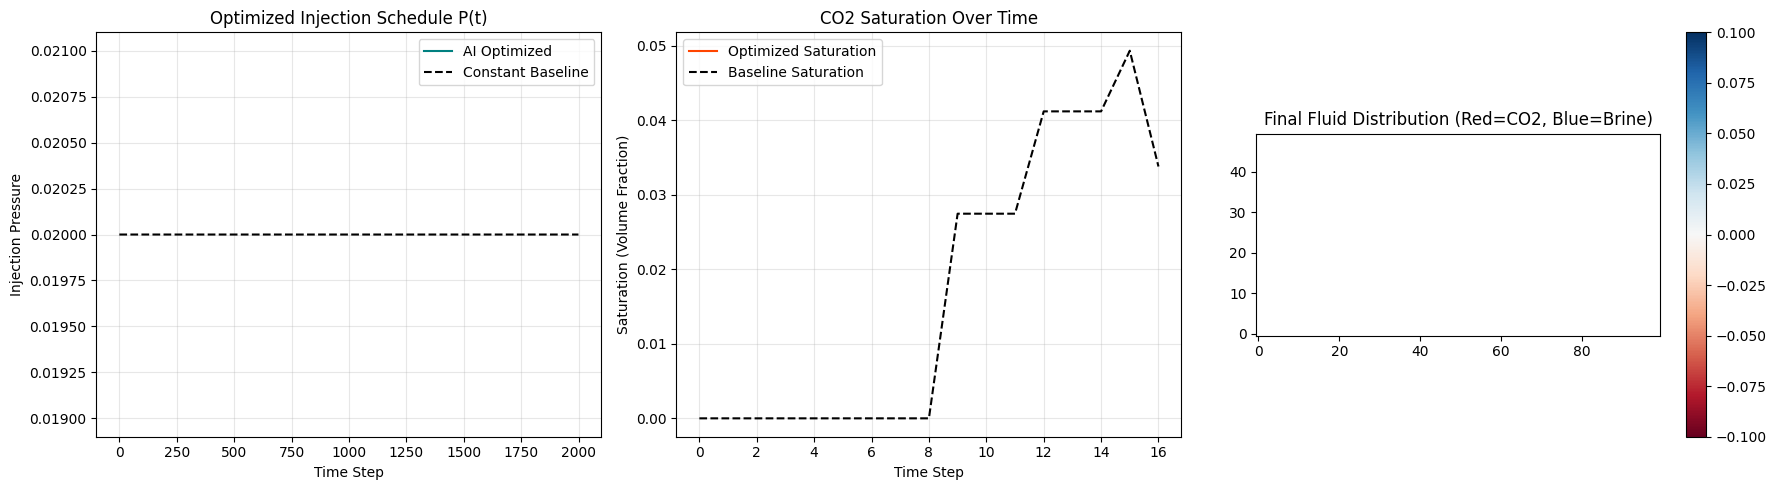

In [11]:
# Run final simulation with optimized schedule
final_state, s_hist_opt = run_simulation(pressure_params, state_init)
_, s_hist_base = run_simulation(jnp.ones(TIME_STEPS)*0.02, state_init) # Baseline

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# 1. The Optimized Injection Schedule
ax[0].plot(pressure_params, color='teal', label='AI Optimized')
ax[0].plot(jnp.ones(TIME_STEPS)*0.02, 'k--', label='Constant Baseline')
ax[0].set_title("Optimized Injection Schedule P(t)")
ax[0].set_xlabel("Time Step")
ax[0].set_ylabel("Injection Pressure")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# 2. Saturation Improvement
ax[1].plot(s_hist_opt, color='orangered', label='Optimized Saturation')
ax[1].plot(s_hist_base, 'k--', label='Baseline Saturation')
ax[1].set_title("CO2 Saturation Over Time")
ax[1].set_xlabel("Time Step")
ax[1].set_ylabel("Saturation (Volume Fraction)")
ax[1].legend()
ax[1].grid(True, alpha=0.3)

# 3. Final Fluid Distribution (Visualizing the "Fingering")
# Extract density from final state
f_final, _, _ = final_state
rho_final = jnp.sum(f_final, axis=-1)
im = ax[2].imshow(rho_final.T, cmap='RdBu', origin='lower')
ax[2].set_title("Final Fluid Distribution (Red=CO2, Blue=Brine)")
plt.colorbar(im, ax=ax[2])

plt.tight_layout()
plt.show()